In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Data visualization

In [2]:
data = pd.read_csv('usdata.csv', header = None)

In [3]:
start_date = "30/09/1947"
end_date = "31/12/2004"
data.index = pd.date_range(start_date, end_date, freq='Q')
data.columns = ['dc', 'dinve', 'dy', 'labobs', 'pinfobs', 'dw', 'robs']

In [4]:
data

,dc,dinve,dy,labobs,pinfobs,dw,robs
1947-09-30,0.125190,3.745902,-0.346647,2.405991,1.733213,-0.390911,0.209167
1947-12-31,-0.311351,7.863267,1.151612,3.120085,2.482240,0.149491,0.251667
1948-03-31,0.429219,3.036307,1.160385,3.722781,0.760128,1.804115,0.272500
1948-06-30,1.102048,1.053555,1.533762,3.705329,0.883676,0.374202,0.275000
1948-09-30,-0.514536,-0.054367,0.247688,3.716847,1.840954,0.628307,0.287500
...,...,...,...,...,...,...,...
2003-12-31,0.477771,2.487176,0.681041,-2.091594,0.352658,0.637123,0.251667
2004-03-31,1.062724,0.843084,1.017161,-1.887397,0.676434,-0.152529,0.250833
2004-06-30,0.134491,3.271152,0.579111,-2.287390,0.786671,0.640072,0.252500
2004-09-30,0.890421,2.167986,0.664565,-1.879071,0.359229,0.983931,0.358333


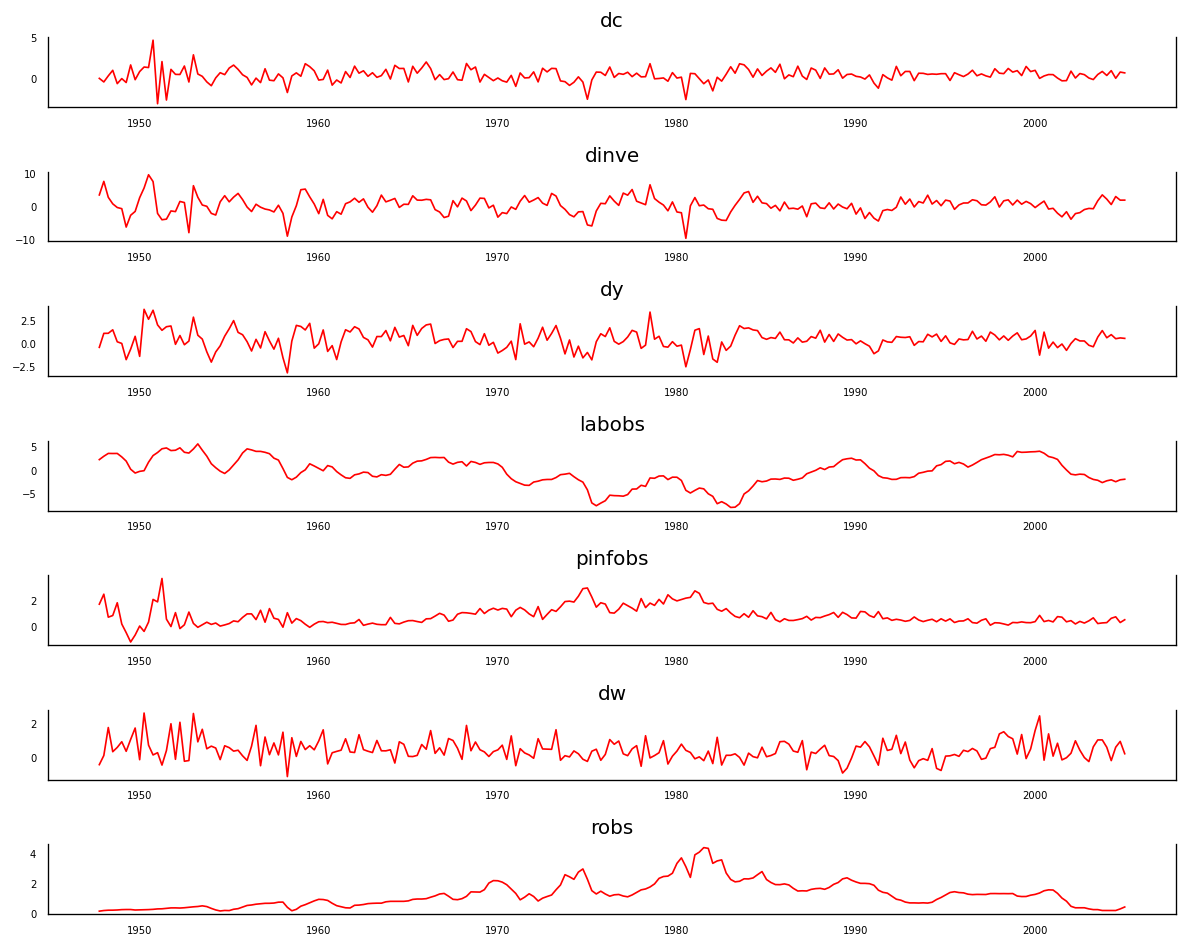

In [5]:
# Plot
fig, axes = plt.subplots(nrows=7, ncols=1, dpi=120, figsize=(10,8))
for i, ax in enumerate(axes.flatten()):
    data_temp = data[data.columns[i]]
    ax.plot(data_temp, color='red', linewidth=1)
    # Decorations
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Vector-autoregression model

## Train-test split

In [6]:
# train-test split without shuffling
nobs = 8
train, test = data[0:-nobs], data[-nobs:]
X_train, Y_train = train[0:-nobs], train[-nobs:]

## Stationarity check

In [7]:
def augmented_dickey_fuller_statistics(time_series):
    result = adfuller(time_series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [8]:
print('Augmented Dickey-Fuller Test: Consumption Time Series')
augmented_dickey_fuller_statistics(X_train['dc'])
print('Augmented Dickey-Fuller Test: Investment Time Series')
augmented_dickey_fuller_statistics(X_train['dinve'])
print('Augmented Dickey-Fuller Test: Output Time Series')
augmented_dickey_fuller_statistics(X_train['dy'])
print('Augmented Dickey-Fuller Test: Labor Time Series')
augmented_dickey_fuller_statistics(X_train['labobs'])
print('Augmented Dickey-Fuller Test: Inflation Time Series')
augmented_dickey_fuller_statistics(X_train['pinfobs'])
print('Augmented Dickey-Fuller Test: Wage Time Series')
augmented_dickey_fuller_statistics(X_train['dw'])
print('Augmented Dickey-Fuller Test: Federal Funds Rate Time Series')
augmented_dickey_fuller_statistics(X_train['robs'])

Augmented Dickey-Fuller Test: Consumption Time Series
ADF Statistic: -7.959492
p-value: 0.000000
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Investment Time Series
ADF Statistic: -5.537069
p-value: 0.000002
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Augmented Dickey-Fuller Test: Output Time Series
ADF Statistic: -10.310731
p-value: 0.000000
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Labor Time Series
ADF Statistic: -3.024506
p-value: 0.032668
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574
Augmented Dickey-Fuller Test: Inflation Time Series
ADF Statistic: -3.149142
p-value: 0.023124
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574
Augmented Dickey-Fuller Test: Wage Time Series
ADF Statistic: -4.000188
p-value: 0.001410
Critical Values:
	1%: -3.462
	5%: -2.876
	10%: -2.574
Augmented Dickey-Fuller Test: Federal Funds Rate Time Series
ADF Statistic: -2.130093
p-value: 0.232587
Critical V

## Order selection

In [9]:
model = VAR(X_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -7.564053753587929
BIC :  -6.680333747579818
FPE :  0.000518896408401419
HQIC:  -7.206913084889726 

Lag Order = 2
AIC :  -7.669763399630522
BIC :  -6.007303216420327
FPE :  0.0004675027082695002
HQIC:  -6.997835826719727 

Lag Order = 3
AIC :  -7.715446877857663
BIC :  -5.269067007927264
FPE :  0.0004482665843704257
HQIC:  -6.726571545605622 

Lag Order = 4
AIC :  -7.640882727145163
BIC :  -4.4053454474516105
FPE :  0.000486414014112377
HQIC:  -6.3328749124129295 

Lag Order = 5
AIC :  -7.528457884960886
BIC :  -3.498466346706663
FPE :  0.0005507801522184765
HQIC:  -5.8991086391165855 

Lag Order = 6
AIC :  -7.521880171227661
BIC :  -2.6920774693521965
FPE :  0.0005645064864440195
HQIC:  -5.568955956008732 

Lag Order = 7
AIC :  -7.449869570859264
BIC :  -1.8148377948067083
FPE :  0.0006225415865785282
HQIC:  -5.1711118874345745 

Lag Order = 8
AIC :  -7.342372450316382
BIC :  -0.8966317156219983
FPE :  0.0007182414425673967
HQIC:  -4.735497461399818 

Lag Order =

By AIC, we choose lag 3.

## Train the model

In [10]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 30, Aug, 2021
Time:                     12:12:55
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -5.26907
Nobs:                     211.000    HQIC:                  -6.72657
Log likelihood:          -1127.79    FPE:                0.000448267
AIC:                     -7.71545    Det(Omega_mle):     0.000223884
--------------------------------------------------------------------
Results for equation dc
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              1.037685         0.193330            5.367           0.000
L1.dc             -0.428698         0.094254           -4.548           0.000
L1.dinve           0.008954         0.032827            0.273           0.7

## Check for serial correlation of residuals

In [11]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(data.columns, out):
    print(col, ':', round(val, 2))

dc : 1.96
dinve : 1.97
dy : 1.98
labobs : 1.98
pinfobs : 1.96
dw : 1.97
robs : 1.94


## Forecast

In [12]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = train.values[-lag_order:]
forecast_input

3


array([[ 0.711647  , -1.61049329,  0.34085369, -0.68008592,  0.44463593,
         0.46350862,  0.4375    ],
       [ 0.57708493, -0.67542912,  0.33625692, -0.75188355,  0.31899486,
         0.02810719,  0.435     ],
       [ 0.16804908, -0.33038731, -0.12530637, -1.3975298 ,  0.48709396,
        -0.21027717,  0.36083333]])

In [13]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
var_forecast = pd.DataFrame(fc, index=data.index[-nobs:], columns=data.columns)
var_forecast.columns = [str(col) + '_var_forecast' for col in var_forecast.columns]
var_forecast

,dc_var_forecast,dinve_var_forecast,dy_var_forecast,labobs_var_forecast,pinfobs_var_forecast,dw_var_forecast,robs_var_forecast
2003-03-31,0.702664,1.418921,1.005135,-1.210742,0.233141,0.552001,0.308415
2003-06-30,1.063478,2.959456,1.282328,-0.532957,0.154605,0.400671,0.350483
2003-09-30,1.158388,2.917860,1.354023,0.085287,0.242951,0.512469,0.416397
2003-12-31,0.964703,2.904340,1.294538,0.721526,0.307332,0.523093,0.461781
2004-03-31,0.990605,2.484532,1.184499,1.287397,0.378156,0.543664,0.523849
2004-06-30,0.852993,2.030081,1.091153,1.753563,0.425294,0.542265,0.593579
2004-09-30,0.776912,1.591791,0.931383,2.076919,0.468792,0.585165,0.650993
2004-12-31,0.686868,1.220091,0.807525,2.282976,0.491248,0.589051,0.699106


## Evaluation

In [14]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mse = np.mean((forecast - actual)**2)  # MSE
    return({ 'mse':mse})

print('Forecast Accuracy of: dc')
accuracy_prod = forecast_accuracy(var_forecast['dc_var_forecast'].values, test['dc'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: dinve')
accuracy_prod = forecast_accuracy(var_forecast['dinve_var_forecast'].values, test['dinve'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: dy')
accuracy_prod = forecast_accuracy(var_forecast['dy_var_forecast'].values, test['dy'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: labobs')
accuracy_prod = forecast_accuracy(var_forecast['labobs_var_forecast'].values, test['labobs'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: pinfobs')
accuracy_prod = forecast_accuracy(var_forecast['pinfobs_var_forecast'].values, test['pinfobs'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: dw')
accuracy_prod = forecast_accuracy(var_forecast['dw_var_forecast'].values, test['dw'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: robs')
accuracy_prod = forecast_accuracy(var_forecast['robs_var_forecast'].values, test['robs'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: dc
mse :  0.1954

Forecast Accuracy of: dinve
mse :  1.3465

Forecast Accuracy of: dy
mse :  0.3412

Forecast Accuracy of: labobs
mse :  9.4155

Forecast Accuracy of: pinfobs
mse :  0.0615

Forecast Accuracy of: dw
mse :  0.1942

Forecast Accuracy of: robs
mse :  0.0492


# Machine learning models

## Train-validation-test split

We only have one time series in total, to be transformed first into train, validation and test sets and then into a supervised learning problem. I shall not randomly split the data into train and validation sets, for efficient use of the data and to prevent leakage. For the train and validation sets, I will split them into overlapping windows of equal lenghs, with the time difference of 1 quarter. Those windows are of the length n_steps + nobs, where n_steps refers to the number of lags and nobs refers to the forecast values. 

In [16]:
n_steps = 10
n_valid = 16
n = data.shape[0]
d = data.shape[1]
n_train = n - nobs - n_valid

In [17]:
test = data[-nobs-n_steps:]
valid = data[-n_steps-n_valid-nobs:-nobs]
train = data[:n_train]

## Splitting into subsequences

We choose to return sequence as output at each step, instead of vector. To be more exact, at timestep 0 the model predicts periods 1-8, and at timestep 1 the model predicts periods 2-9, until the last timestep. The input is a 3D array of (sample size, time steps, features). The target, as windows for each timestep in the input, should be a 4D array, with one more dimension "nobs". However, the sequential api only takes in 3D arrays. In fact, only the first two arguments need to be identified as they have to match the weight matrices. So I just have to merge the last 2 dimensions in the target into 1 dimension, keeping in mind of the items in different positions. For instance, for the input, in the vertical direction lies the features for each sample. I create the target so that features for different forward-looking periods are stacked together. 

In [18]:
# Split train set into subsequences
X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
Y_train = np.empty((n_train - n_steps - nobs, n_steps, d * nobs))
for i in range(n_train - n_steps - nobs):
    X_train[i, :, :] = train[i : i+n_steps]
    for j in range(nobs):
        Y_train[i, :, j*d:(j+1)*d] = train[i+j+1 : i+j+n_steps+1]

In [19]:
X_train.shape, Y_train.shape

((188, 10, 7), (188, 10, 56))

In [20]:
# Split validation set into subsequences
X_valid = np.empty((n_valid - nobs, n_steps, d))
Y_valid = np.empty((n_valid - nobs, n_steps, d * nobs))
for i in range(n_valid - nobs):
    X_valid[i, :, :] = valid[i : i+n_steps]
    for j in range(nobs):
        Y_valid[i, :, j*d:(j+1)*d] = valid[i+j+1 : i+j+n_steps+1]

In [21]:
X_valid.shape, Y_valid.shape

((8, 10, 7), (8, 10, 56))

In [22]:
# Split test set into subsequences
X_test = np.array(data[-nobs-n_steps:-nobs])
Y_test = np.empty((n_steps, d * nobs))
for j in range(nobs):
    Y_test[:, j*d : (j+1)*d] = test[j+1 : j+n_steps+1]

In [23]:
X_test.shape, Y_test.shape

((10, 7), (10, 56))

In [24]:
X_test = X_test.reshape(1, n_steps, d)
Y_test = Y_test.reshape(1, n_steps, d * nobs)

In [25]:
X_test.shape, Y_test.shape

((1, 10, 7), (1, 10, 56))

## Normalization

MinMaxScaler from sklearn can only normalize against 2D arrays. Here I am normalizing along the 3rd axis--in other words, across the 1st and 2nd axis. Therefore I normalize the data like below:

In [26]:
X_min = X_train.min(axis=(0, 1), keepdims=True)
X_max = X_train.max(axis=(0, 1), keepdims=True)
X_train_norm = (X_train - X_min)/(X_max - X_min)

In [27]:
Y_min = Y_train.min(axis=(0, 1), keepdims=True)
Y_max = Y_train.max(axis=(0, 1), keepdims=True)
Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)

In [28]:
X_valid_norm = (X_valid - X_min)/(X_max - X_min)
Y_valid_norm = (Y_valid - Y_valid)/(Y_max - Y_min)

## Hyperparameter tuning for the RNN model

We are interested in tuning the following hyperparemeters:

1. Number of time steps
2. Number of hidden layers
3. Number of neurons per hidden layer
4. Learning rate

In [165]:
def build_model(n_hidden=1, n_neurons=20, learning_rate=3e-3, input_shape=[None, 7]):
    model = keras.models.Sequential()
    model.add(keras.layers.SimpleRNN(n_neurons, return_sequences = True, input_shape = input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.SimpleRNN(n_neurons, return_sequences = True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(d*nobs)))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [166]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

Due to computational constraint of my computer, I will have to separate the selection of model-related hyperparameters and time steps and epochs, and select them in sequence.

### Select number of hidden layers, number of neurons per hidden layer and learning rate

In [167]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(2, 10, 2).tolist(),
    "learning_rate":[0.001, 0.003, 0.05]
}

In [168]:
from sklearn.model_selection import ParameterGrid

best_score = -np.inf
for g in ParameterGrid(param_distribs):
    keras_reg.set_params(**g)
    keras_reg.fit(X_train_norm, Y_train_norm, epochs=100)
    # save if best
    mse_valid = keras_reg.score(X_valid_norm, Y_valid_norm)
    if mse_valid > best_score:
        best_score = mse_valid
        best_grid = g

Epoch 1/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2381
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2316
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2254
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.2193
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.2132
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 0.2072
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.2009
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1946
Epoch 9/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1881
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1814
Epoch 11/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1746
Epoch 12/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1675
Epoch 13/100
6/6 [==============================] - 0s 3ms/st

In [169]:
best_grid

{'learning_rate': 0.003, 'n_hidden': 3, 'n_neurons': 4}

### Select number of time steps

In [170]:
best_score = -np.inf
best_timesteps = 5

timesteps_grid = np.arange(1, 20, 2)

for n_steps in timesteps_grid:
    
    # Train-validation-test split
    test = data[-nobs-n_steps:]
    valid = data[-n_steps-n_valid-nobs:-nobs]
    train = data[:n_train]
    
    # Split train set into subsequences
    X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
    Y_train = np.empty((n_train - n_steps - nobs, n_steps, d * nobs))
    for i in range(n_train - n_steps - nobs):
        X_train[i, :, :] = train[i : i+n_steps]
        for j in range(nobs):
            Y_train[i, :, j*d:(j+1)*d] = train[i+j+1 : i+j+n_steps+1]
    
    # Split validation set into subsequences
    X_valid = np.empty((n_valid - nobs, n_steps, d))
    Y_valid = np.empty((n_valid - nobs, n_steps, d * nobs))
    for i in range(n_valid - nobs):
        X_valid[i, :, :] = valid[i : i+n_steps]
        for j in range(nobs):
            Y_valid[i, :, j*d:(j+1)*d] = valid[i+j+1 : i+j+n_steps+1]
    
    # Normalization
    X_min = X_train.min(axis=(0, 1), keepdims=True)
    X_max = X_train.max(axis=(0, 1), keepdims=True)
    X_train_norm = (X_train - X_min)/(X_max - X_min)
    
    Y_min = Y_train.min(axis=(0, 1), keepdims=True)
    Y_max = Y_train.max(axis=(0, 1), keepdims=True)
    Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)
    
    X_valid_norm = (X_valid - X_min)/(X_max - X_min)
    Y_valid_norm = (Y_valid - Y_valid)/(Y_max - Y_min)
    
    # fit
    keras_reg.set_params(**best_grid)
    keras_reg.fit(X_train_norm, Y_train_norm, epochs=100)
    # save if best
    mse_valid = keras_reg.score(X_valid_norm, Y_valid_norm)
    if mse_valid > best_score:
        best_score = mse_valid
        best_timesteps = n_steps

Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 0.2229
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 0.1854
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 0.1477
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 0.1116
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0807
Epoch 6/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0577
Epoch 7/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0432
Epoch 8/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0347
Epoch 9/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0305
Epoch 10/100
7/7 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 11/100
7/7 [==============================] - 0s 997us/step - loss: 0.0280
Epoch 12/100
7/7 [==============================] - 0s 997us/step - loss: 0.0278
Epoch 13/100
7/7 [==============================] - 0s 99

In [171]:
best_timesteps

9

## RNN fit and predict

In [67]:
n_steps = 9

test = data[-nobs-n_steps:]
valid = data[-n_steps-n_valid-nobs:-nobs]
train = data[:n_train]

# Split train set into subsequences
X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
Y_train = np.empty((n_train - n_steps - nobs, n_steps, d * nobs))
for i in range(n_train - n_steps - nobs):
    X_train[i, :, :] = train[i : i+n_steps]
    for j in range(nobs):
        Y_train[i, :, j*d:(j+1)*d] = train[i+j+1 : i+j+n_steps+1]

# Split validation set into subsequences
X_valid = np.empty((n_valid - nobs, n_steps, d))
Y_valid = np.empty((n_valid - nobs, n_steps, d * nobs))
for i in range(n_valid - nobs):
    X_valid[i, :, :] = valid[i : i+n_steps]
    for j in range(nobs):
        Y_valid[i, :, j*d:(j+1)*d] = valid[i+j+1 : i+j+n_steps+1]

X_min = X_train.min(axis=(0, 1), keepdims=True)
X_max = X_train.max(axis=(0, 1), keepdims=True)
X_train_norm = (X_train - X_min)/(X_max - X_min)

Y_min = Y_train.min(axis=(0, 1), keepdims=True)
Y_max = Y_train.max(axis=(0, 1), keepdims=True)
Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)

X_valid_norm = (X_valid - X_min)/(X_max - X_min)
Y_valid_norm = (Y_valid - Y_valid)/(Y_max - Y_min)

In [68]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(4, return_sequences = True, input_shape = [None, 7]),
    keras.layers.SimpleRNN(4, return_sequences = True),
    keras.layers.SimpleRNN(4, return_sequences = True),
    keras.layers.SimpleRNN(4, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(d*nobs))
])

In [69]:
optimizer = keras.optimizers.Adam(learning_rate=0.003)

In [70]:
model.compile(loss='mse', optimizer=optimizer)

In [71]:
history = model.fit(X_train_norm, Y_train_norm, epochs = 100, validation_data = (X_valid_norm, Y_valid_norm),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
6/6 [==============================] - 1s 168ms/step - loss: 0.2658 - val_loss: 0.0359
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.2218 - val_loss: 0.0416
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1808 - val_loss: 0.0588
Epoch 4/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1437 - val_loss: 0.0852
Epoch 5/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1123 - val_loss: 0.1137
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0873 - val_loss: 0.1386
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0686 - val_loss: 0.1587
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0552 - val_loss: 0.1741
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0459 - val_loss: 0.1856
Epoch 10/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0397 - val_loss: 0.1952
Epoch 11/100
6/6 [=========

In [72]:
# Normalize test set
X_test_norm = (X_test - X_min)/(X_max - X_min)
# Predict
Y_pred_norm = model.predict(X_test_norm)
# Denormalize target
Y_pred = Y_pred_norm * (Y_max - Y_min) + Y_min

We are only interested in the output from the last time step. And the output is made up of 8 periods of 7 features. To compute the MSE, I do the following reshape.

In [73]:
Y_pred_last_step = Y_pred[:, -1, :].reshape(nobs, d)
Y_test_last_step = Y_test[:, -1, :].reshape(nobs, d)
np.mean((Y_pred_last_step - Y_test_last_step)**2, axis = 0)

array([0.31242419, 5.34061019, 1.3640372 , 3.1047215 , 0.2086459 ,
       0.20606081, 1.24635526])

The train and validation loss shown below are the mse for all time steps and for the normalized targets.

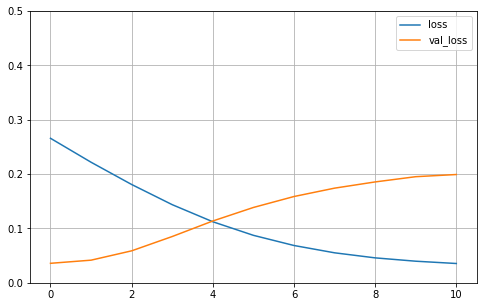

In [74]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.5)
plt.show()

In [75]:
rnn_columns = [str(col) + '_rnn_forecast' for col in data.columns]

In [76]:
rnn_forecast = pd.DataFrame(Y_pred_last_step, index = var_forecast.index, columns = rnn_columns)

In [77]:
rnn_forecast

,dc_rnn_forecast,dinve_rnn_forecast,dy_rnn_forecast,labobs_rnn_forecast,pinfobs_rnn_forecast,dw_rnn_forecast,robs_rnn_forecast
2003-03-31,0.055718,0.422630,0.642700,-0.128417,1.085042,0.565915,1.449071
2003-06-30,0.800593,1.173891,0.630352,0.227744,0.766522,0.415118,1.423667
2003-09-30,0.725059,-1.353633,0.757005,-2.106503,0.924655,0.462638,1.398316
2003-12-31,0.643798,0.436460,-2.306134,-2.454013,0.848257,0.423387,1.389515
2004-03-31,-0.360162,0.177163,0.313691,0.257800,0.674605,0.498280,1.361933
2004-06-30,0.549967,0.701278,0.212245,0.404887,0.707709,0.555528,1.376902
2004-09-30,0.505275,1.076101,0.655675,-3.188561,1.061180,0.419368,1.567091
2004-12-31,0.642971,0.565965,0.609334,0.063700,1.011762,0.457926,1.424948


## Hyperparameter tuning for the LSTM model

We are interested in tuning the following hyperparemeters:

1. Number of time steps
2. Number of hidden layers
3. Number of neurons per hidden layer
4. Learning rate

In [30]:
def build_model(n_hidden=1, n_neurons=20, learning_rate=3e-3, input_shape=[None, 7]):
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(n_neurons, return_sequences = True, input_shape = input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.LSTM(n_neurons, return_sequences = True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(d*nobs)))
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [31]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

Due to computational constraint of my computer, I will have to separate the selection of model-related hyperparameters and time steps and epochs, and select them in sequence.

### Select number of hidden layers, number of neurons per hidden layer and learning rate

In [230]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(2, 30, 2).tolist(),
    "learning_rate":[0.003, 0.005, 0.01]
}

In [231]:
from sklearn.model_selection import ParameterGrid

for g in ParameterGrid(param_distribs):
    keras_reg.set_params(**g)
    keras_reg.fit(X_train_norm, Y_train_norm, epochs=100)
    # save if best
    mse_valid = keras_reg.score(X_valid_norm, Y_valid_norm)
    if mse_valid > best_score:
        best_score = mse_valid
        best_grid = g

Epoch 1/100
6/6 [==============================] - 0s 4ms/step - loss: 0.2361
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.2140
Epoch 3/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1951
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1781
Epoch 5/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1619
Epoch 6/100
6/6 [==============================] - 0s 3ms/step - loss: 0.1460
Epoch 7/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1306
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1157
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 0.1013
Epoch 10/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0877
Epoch 11/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0748
Epoch 12/100
6/6 [==============================] - 0s 2ms/step - loss: 0.0631
Epoch 13/100
6/6 [==============================] - 0s 2ms/st

ResourceExhaustedError:  OOM when allocating tensor with shape[32,11,56] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2_1}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_4396513]

Function call stack:
train_function


In [232]:
best_grid

{'learning_rate': 0.003, 'n_hidden': 3, 'n_neurons': 24}

### Select number of time steps

In [33]:
best_score = -np.inf
best_timesteps = 5

timesteps_grid = np.arange(1, 20, 2)

for n_steps in timesteps_grid:
    
    # Train-validation-test split
    test = data[-nobs-n_steps:]
    valid = data[-n_steps-n_valid-nobs:-nobs]
    train = data[:n_train]
    
    # Split train set into subsequences
    X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
    Y_train = np.empty((n_train - n_steps - nobs, n_steps, d * nobs))
    for i in range(n_train - n_steps - nobs):
        X_train[i, :, :] = train[i : i+n_steps]
        for j in range(nobs):
            Y_train[i, :, j*d:(j+1)*d] = train[i+j+1 : i+j+n_steps+1]
    
    # Split validation set into subsequences
    X_valid = np.empty((n_valid - nobs, n_steps, d))
    Y_valid = np.empty((n_valid - nobs, n_steps, d * nobs))
    for i in range(n_valid - nobs):
        X_valid[i, :, :] = valid[i : i+n_steps]
        for j in range(nobs):
            Y_valid[i, :, j*d:(j+1)*d] = valid[i+j+1 : i+j+n_steps+1]
    
    # Normlization
    X_min = X_train.min(axis=(0, 1), keepdims=True)
    X_max = X_train.max(axis=(0, 1), keepdims=True)
    X_train_norm = (X_train - X_min)/(X_max - X_min)
    
    Y_min = Y_train.min(axis=(0, 1), keepdims=True)
    Y_max = Y_train.max(axis=(0, 1), keepdims=True)
    Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)
    
    X_valid_norm = (X_valid - X_min)/(X_max - X_min)
    Y_valid_norm = (Y_valid - Y_valid)/(Y_max - Y_min)
    
    # Fit
    keras_reg.set_params(**best_grid)
    keras_reg.fit(X_train_norm, Y_train_norm, epochs=100)
    # save if best
    mse_valid = keras_reg.score(X_valid_norm, Y_valid_norm)
    if mse_valid > best_score:
        best_score = mse_valid
        best_timesteps = n_steps

Epoch 1/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2297
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2041
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.1685
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.1109
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0464
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0402
Epoch 7/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 8/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0296
Epoch 9/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0285
Epoch 10/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0283
Epoch 11/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0279
Epoch 12/100
7/7 [==============================] - 0s 4ms/step - loss: 0.0278
Epoch 13/100
7/7 [==============================] - 0s 5ms/st

In [34]:
best_timesteps

13

## LSTM fit and predict

In [78]:
n_steps = 13

test = data[-nobs-n_steps:]
valid = data[-n_steps-n_valid-nobs:-nobs]
train = data[:n_train]

# Split train set into subsequences
X_train = np.empty((n_train - n_steps - nobs, n_steps, d))
Y_train = np.empty((n_train - n_steps - nobs, n_steps, d * nobs))
for i in range(n_train - n_steps - nobs):
    X_train[i, :, :] = train[i : i+n_steps]
    for j in range(nobs):
        Y_train[i, :, j*d:(j+1)*d] = train[i+j+1 : i+j+n_steps+1]

# Split validation set into subsequences
X_valid = np.empty((n_valid - nobs, n_steps, d))
Y_valid = np.empty((n_valid - nobs, n_steps, d * nobs))
for i in range(n_valid - nobs):
    X_valid[i, :, :] = valid[i : i+n_steps]
    for j in range(nobs):
        Y_valid[i, :, j*d:(j+1)*d] = valid[i+j+1 : i+j+n_steps+1]

X_min = X_train.min(axis=(0, 1), keepdims=True)
X_max = X_train.max(axis=(0, 1), keepdims=True)
X_train_norm = (X_train - X_min)/(X_max - X_min)

Y_min = Y_train.min(axis=(0, 1), keepdims=True)
Y_max = Y_train.max(axis=(0, 1), keepdims=True)
Y_train_norm = (Y_train - Y_min)/(Y_max - Y_min)

X_valid_norm = (X_valid - X_min)/(X_max - X_min)
Y_valid_norm = (Y_valid - Y_valid)/(Y_max - Y_min)

In [79]:
model = keras.models.Sequential([
    keras.layers.LSTM(24, return_sequences = True, input_shape = [None, 7]),
    keras.layers.LSTM(24, return_sequences = True),
    keras.layers.LSTM(24, return_sequences = True),
    keras.layers.LSTM(24, return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(d*nobs))
])

In [80]:
optimizer = keras.optimizers.Adam(learning_rate=0.003)

In [81]:
model.compile(loss='mse', optimizer=optimizer)

In [82]:
history = model.fit(X_train_norm, Y_train_norm, epochs = 100, validation_data = (X_valid_norm, Y_valid_norm), callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
6/6 [==============================] - 1s 217ms/step - loss: 0.2219 - val_loss: 0.0093
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 0.1586 - val_loss: 0.1442
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.1005 - val_loss: 0.1336
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0635 - val_loss: 0.1669
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0477 - val_loss: 0.1962
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0404 - val_loss: 0.1861
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0363 - val_loss: 0.1959
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0335 - val_loss: 0.1944
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0317 - val_loss: 0.2007
Epoch 10/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0303 - val_loss: 0.2021
Epoch 11/100
6/6 [

In [83]:
# Normalize test set
X_test_norm = (X_test - X_min)/(X_max - X_min)
# Predict
Y_pred_norm = model.predict(X_test_norm)
# Denormalize target
Y_pred = Y_pred_norm * (Y_max - Y_min) + Y_min

We are only interested in the output from the last time step. And the output is made up of 8 periods of 7 features. To compute the MSE, I do the following reshape.

In [84]:
Y_pred_last_step = Y_pred[:, -1, :].reshape(nobs, d)
Y_test_last_step = Y_test[:, -1, :].reshape(nobs, d)
# MSE
np.mean((Y_pred_last_step - Y_test_last_step)**2, axis = 0)

array([0.14760218, 3.88878792, 0.23640861, 2.54277626, 0.19626807,
       0.1990168 , 1.3154753 ])

The train and validation loss shown below are the mse for all time steps and for the normalized targets.

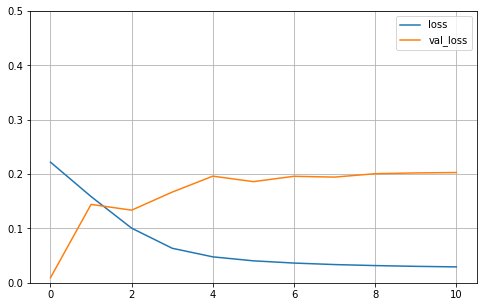

In [85]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,0.5)
plt.show()

In [86]:
lstm_columns = [str(col) + '_lstm_forecast' for col in data.columns]

In [87]:
lstm_forecast = pd.DataFrame(Y_pred_last_step, index = var_forecast.index, columns = lstm_columns)

In [88]:
lstm_forecast

,dc_lstm_forecast,dinve_lstm_forecast,dy_lstm_forecast,labobs_lstm_forecast,pinfobs_lstm_forecast,dw_lstm_forecast,robs_lstm_forecast
2003-03-31,0.518480,0.453236,0.478554,-0.516889,0.924767,0.463077,1.479794
2003-06-30,0.814767,0.561121,0.548807,-0.394306,0.901257,0.458974,1.425489
2003-09-30,0.503703,0.379614,0.526611,-0.456615,0.845939,0.425014,1.435041
2003-12-31,0.560006,0.664615,0.479404,-0.542382,0.906325,0.435633,1.448451
2004-03-31,0.502072,0.224470,0.470026,-0.307606,0.950728,0.398950,1.431168
2004-06-30,0.456034,0.430633,0.475801,-0.524639,0.954557,0.408379,1.497275
2004-09-30,0.619612,0.728741,0.466175,-0.355738,0.955159,0.407434,1.431294
2004-12-31,0.423980,0.463099,0.476016,-0.427172,0.900413,0.420301,1.487487


# Comparison

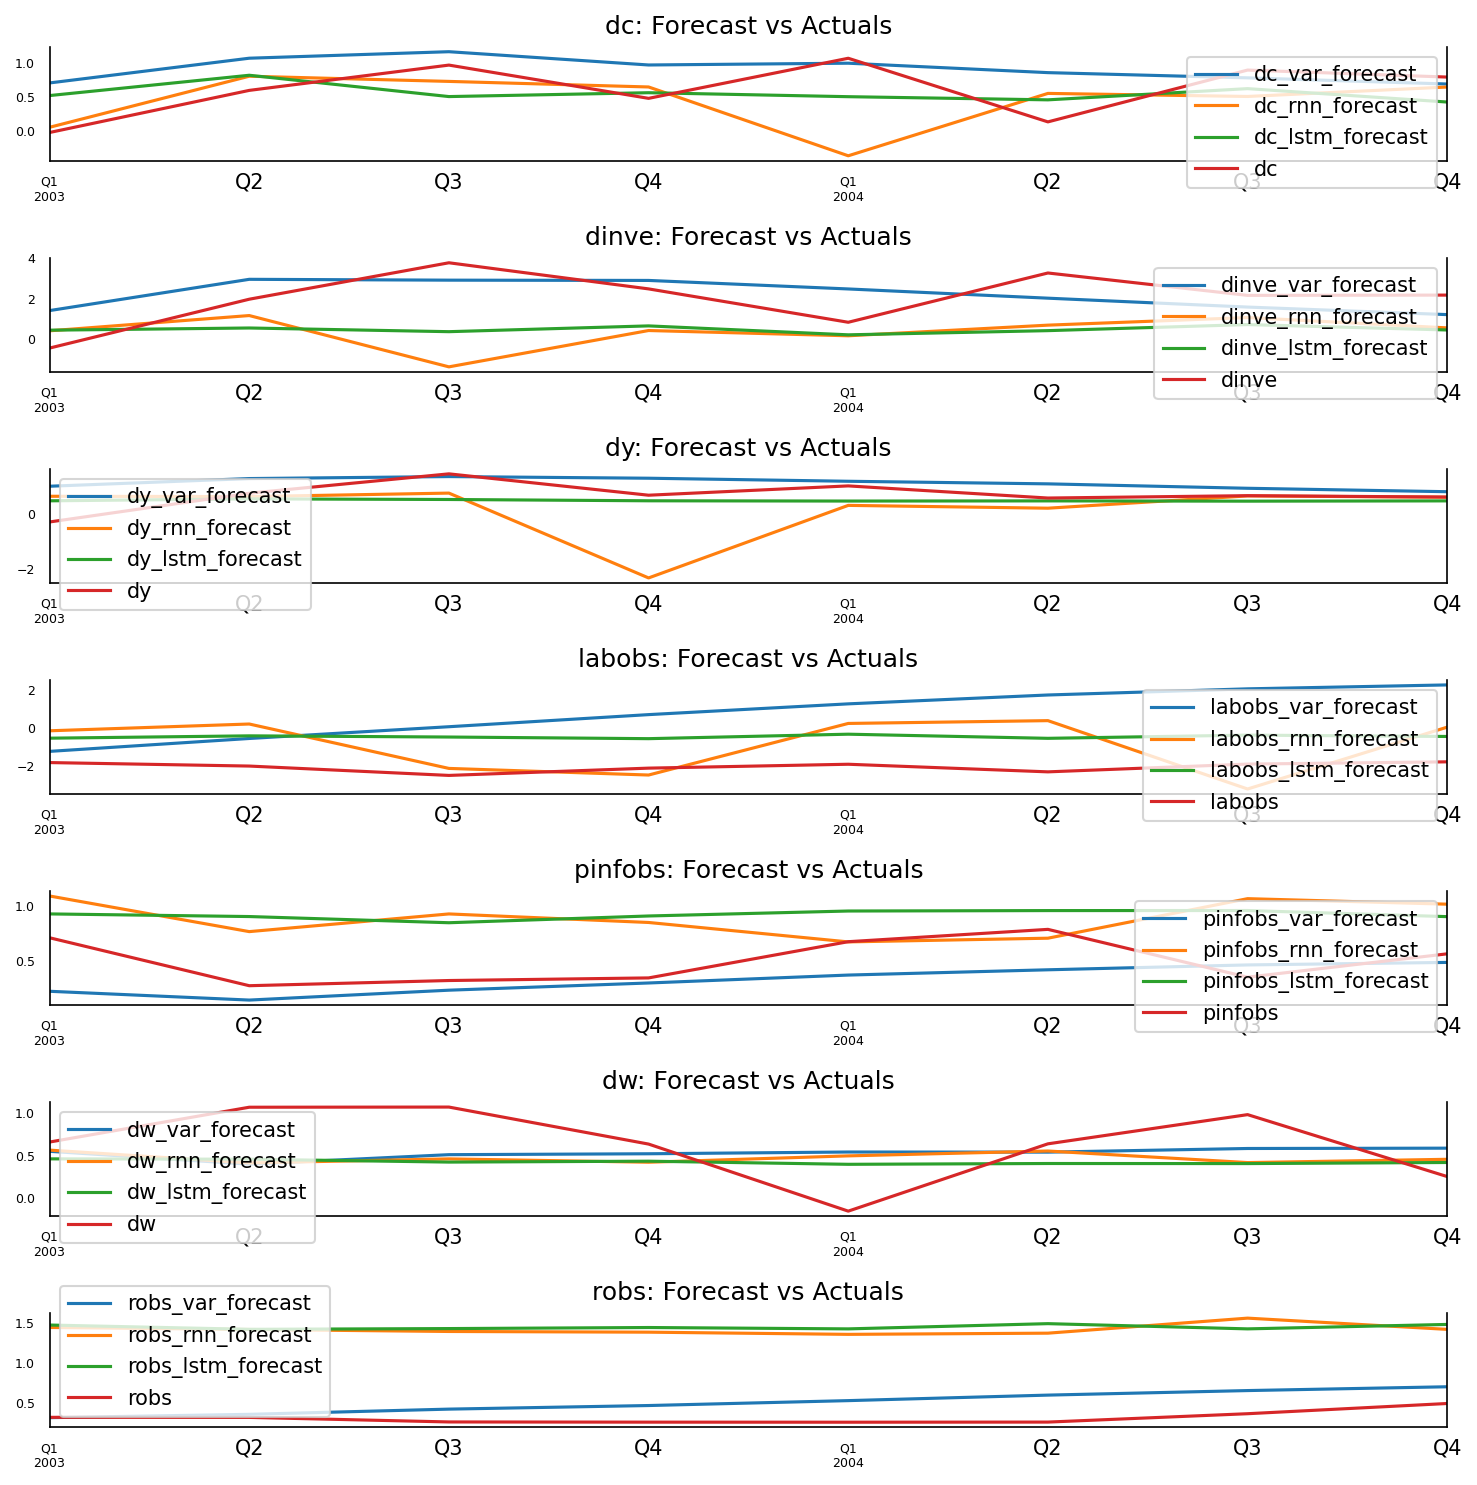

In [89]:
fig, axes = plt.subplots(nrows=int(len(data.columns)), ncols=1, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(data.columns, axes.flatten())):
    var_forecast[col+'_var_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    rnn_forecast[col+'_rnn_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    lstm_forecast[col+'_lstm_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();